# EDA

Nos disponemos a hacer un ```Análisis Exploratorio de Datos``` **(EDA)** con la finalidad de entender nuestros datos en profundidad y observar en ellos transformaciones potenciales de cara a mejorar el rendimiento de los modelos de predicción que empleemos

In [1]:
# Librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from warnings import filterwarnings

filterwarnings('ignore') # Para ahorrarnos warnings molestos

In [3]:
# Importamos TODOS los datos
# Precios e IPC
precios = pd.read_csv("Data/Precios por mes.csv")
ipc = pd.read_excel("Data/IPC energía - Eurostat.xlsx", sheet_name = "Sheet 2")

# Demanda nacional y por CCAA
demanda = pd.read_csv("Data/demanda_nacional.csv")
demanda_ccaa = pd.read_csv("Data/demanda_comunidades.csv")

# Intercambio y generación energética
intercambio = pd.read_csv("Data/intercambio.csv")
generacion_no_ren = pd.read_csv("Data/GeneracionDiariaRenNoRen.csv")
generacion = pd.read_csv("Data/GeneracionDiariaXTecnologia.csv")

# Emisiones de CO2
emision = pd.read_csv("Data/EmisionesDiarias.csv")

----

Una primera anotación es que todos los dataframes cargados, a excepción de ```ipc``` tienen la columna **"Unnamed: 0"**, que corresponde a sus antiguos índices, por lo que haremos una función y la eliminaremos

In [4]:
variables = [precios, demanda, demanda_ccaa, intercambio, emision, generacion_no_ren, generacion]

for df in variables:
    try:
        df.drop("Unnamed: 0", axis = 1, inplace = True)
        
    except:
        pass

----

# EDA por categorías

## Precios

In [5]:
precios.head(5)

€/Mwh       Meses
0  59.90  2014-09-01
1  56.84  2014-10-01
2  48.68  2014-11-01
3  49.43  2014-12-01
4  53.54  2015-01-01

In [6]:
precios.tail(5)

€/Mwh       Meses
103  74.34  2023-04-01
104  74.35  2023-05-01
105  93.85  2023-06-01
106  91.21  2023-07-01
107  80.23  2023-08-01

In [7]:
precios.info() # Buscamos valores no nulos y qué tipo de datos tenemos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   €/Mwh   108 non-null    float64
 1   Meses   108 non-null    object 
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


----

Observamos que, debido a los ```valores anomarlmente elevados que se dieron durante los años 2022 y parte de 2021 y 2023```, la distribución de los datos se ve notablemente afectada y representa un problema conocido en estadística como ```"cola pesada"```, que se da cuando valores de baja densidad **(muy rara frecuencia)** no son exponencialmente raros. Esto puede afectar negativamente a los modelos y, especialmente, a la estandarización de los datos, pues altera enormemente la **media y la desviación típica.**

In [8]:
maximo = precios[precios['€/Mwh'] == precios['€/Mwh'].max()] # Obtenemos el dato exacto del máximo de precios
minimo = precios[precios['€/Mwh'] == precios['€/Mwh'].min()] # Hacemos lo mismo, pero para obtener el mínimo


valores_extremos = pd.concat([maximo, minimo]) # Los juntamos como un único dataframe


fig = px.line(precios, x = 'Meses', y = '€/Mwh') # Graficamos la serie temporal de precios
fig.add_trace(px.scatter(valores_extremos, x = 'Meses', y = '€/Mwh').data[0]) # Añadimos un "scatter" de solo dos puntos (el máximo y el mínimo)

fig.show()

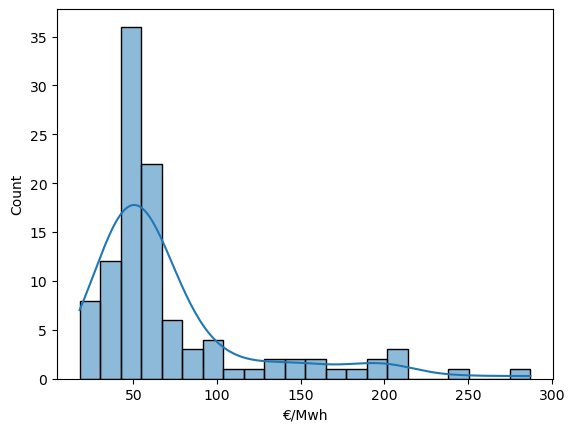

In [9]:
sns.histplot(precios['€/Mwh'], kde = True)
plt.show()

Usualmente, aplicar una **transformación logarítmica** ayuda a aliviar este crecimiento exponencial de valores de baja densidad, lo cual mejora el desempeño de los modelos al trabajar con estos datos estandarizados

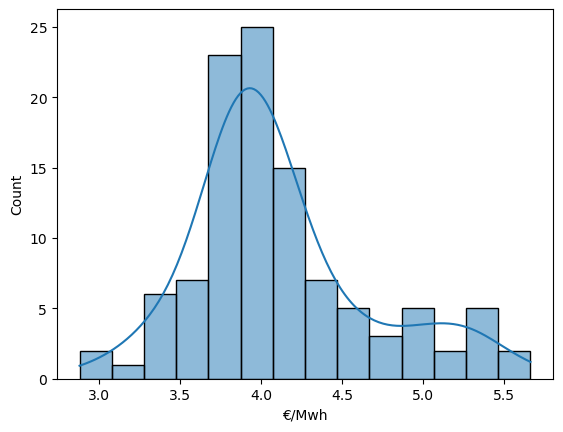

In [10]:
log_price = np.log(precios['€/Mwh'])

sns.histplot(log_price, kde = True)
plt.show()

In [11]:
precios['€/Mwh'] = np.log(precios['€/Mwh'])

precios.to_csv('Precios (logaritmo).csv')

## IPC

In [12]:
ipc.head(5)

TIME  Spain
0  1996-01  60.88
1      NaN    NaN
2  1996-02  60.88
3      NaN    NaN
4  1996-03  60.88

In [13]:
ipc.tail(5)

TIME  Spain
656  2023-05  97.26
657      NaN    NaN
658  2023-06  99.49
659      NaN    NaN
660  2023-07      :

Si observamos detenidamente, comprobaremos que los valores NaN son solamente espacios en blanco que se deben a saltos sin datos en el Excel, por lo que aplicar un dropna no debería generar problemas, pues no estamos borrando ningún dato.

Si está suposición es cierta, debemos tener una fila con NaN por cada fila con datos. Ergo, si eliminamos todas las filas con NaN y son solo filas en blanco sin datos, "perderemos" la mitad de las filas.

In [14]:
ipc.shape

(661, 2)

In [15]:
ipc.dropna(inplace = True)

ipc.shape # En efecto. Perdemos aproximadamente la mitad de las filas

(331, 2)

In [16]:
ipc.iloc[-1] # Esto se debe a otro error del Excel, por lo que deberemos seleccionar todas las filas salvo la última

TIME     2023-07
Spain          :
Name: 660, dtype: object

In [17]:
ipc = ipc.iloc[:-1]

ipc.iloc[-1] # Comprobamos que se ha solucionado

TIME     2023-06
Spain      99.49
Name: 658, dtype: object

In [18]:
ipc.reset_index(drop = True, inplace = True)

Observamos que con el IPC ocurre lo mismo que con los precios. Según transcurren los años 2021, 2022 y parte del 2023 se tienen datos anormalmente grandes con causa en la guerra de ucrania y la pandemia de la Covid-19. Por tanto, para tratar de lidiar con estos ```black swans``` probaremos realizando una **transformación logarítmica**

In [19]:
px.line(data_frame = ipc,
        x = ipc['TIME'],
        y = ipc['Spain'])

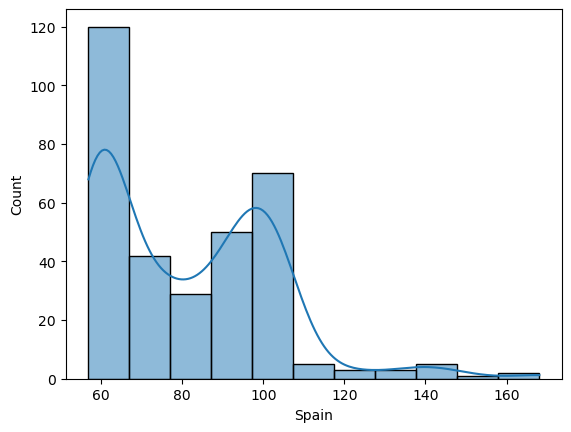

In [20]:
sns.histplot(ipc['Spain'], kde = True)
plt.show()

In [21]:
ipc['Spain'] = ipc['Spain'].astype('float')

log_ipc = np.log(ipc['Spain'])

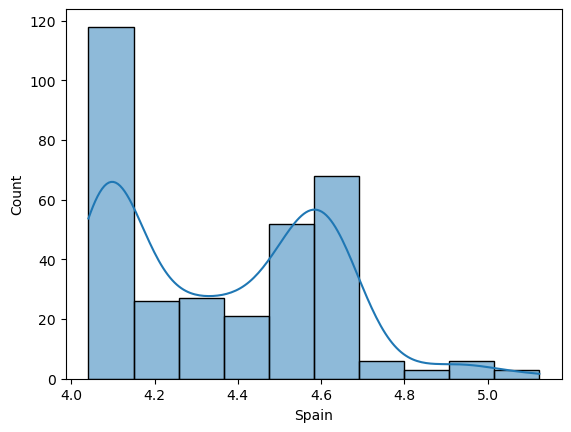

In [22]:
sns.histplot(log_ipc, kde = True)
plt.show()

La distribución no varía, pero observamos que el rango de valores en el que se distribuyen las frecuencias es más compacto, ante lo cual se aprecia una visible mejoría

In [23]:
ipc['Spain'] = np.log(ipc['Spain'])

ipc.to_csv('IPC (logaritmo).csv')

## Demanda

### Nacional

In [24]:
demanda.head(5)

Fecha  Energia Consumida Mw/h
0  2011-01-01                  605.99
1  2011-01-02                  641.86
2  2011-01-03                  801.30
3  2011-01-04                  833.25
4  2011-01-05                  803.48

In [25]:
demanda.tail(5)

Fecha  Energia Consumida Mw/h
4378  2022-12-27                  611.57
4379  2022-12-28                  629.53
4380  2022-12-29                  636.82
4381  2022-12-30                  623.61
4382  2022-12-31                  559.27

In [26]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fecha                   4383 non-null   object 
 1   Energia Consumida Mw/h  4383 non-null   float64
dtypes: float64(1), object(1)
memory usage: 68.6+ KB


In [27]:
fig2 = px.line(data_frame = demanda, x = "Fecha", y = "Energia Consumida Mw/h")

fig2.show()

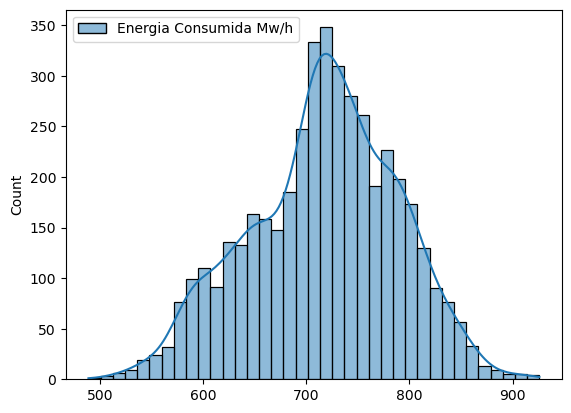

In [28]:
sns.histplot(demanda, kde = True)
plt.show()

Observamos que la demanda nacional sigue una distribución similar a una normal o gaussiana, con lo cual no es necesario realizar sobre ella algún tipo de transformación, pues no presentaría problemas al ser estandarizada

### Por comunidades autónomas

In [29]:
demanda_ccaa.head(5)

Fecha  Andalucia  Aragon  Cantabria  Castilla-La Mancha  \
0  2011-01-01    3611.37  956.50     394.46             1151.08   
1  2011-02-01    3206.56  872.53     366.57             1039.33   
2  2011-03-01    3363.76  942.54     402.78             1092.29   
3  2011-04-01    2902.82  825.73     361.94              895.00   
4  2011-05-01    2988.73  874.73     379.05              942.66   

   Castilla-Leon  Cataluña  Pais Vasco  Asturias  Ceuta  Melilla   Madrid  \
0        1308.02   4342.58     1653.04   1020.15  16.75    18.09  2989.14   
1        1189.42   3908.14     1590.31    920.40  15.25    16.47  2693.27   
2        1264.48   4218.75     1742.78    986.15  16.43    17.21  2819.43   
3        1039.44   3592.54     1442.49    881.85  14.97    15.69  2245.19   
4        1106.83   3886.56     1545.96    910.10  16.13    16.93  2372.78   

   Navarra  Valencia  Extremadura  Galicia  Baleares  Canarias  La Rioja  \
0   442.76   2526.98       462.01  1856.31    477.26    744.52    163.77   
1   419.33   2271.57       407.24  1674.72    430.51    668.99    151.47   
2   453.44   2373.75       437.54  1789.36    454.44    736.78    162.84   
3   378.08   1961.97       353.80  1583.51    393.42    697.16    130.21   
4   415.01   2095.02       368.54  1613.76    454.31    717.47    141.86   

   Murcia  
0  731.16  
1  652.48  
2  685.60  
3  592.38  
4  627.60

In [30]:
demanda_ccaa.tail(5)

Fecha  Andalucia  Aragon  Cantabria  Castilla-La Mancha  \
139  2022-08-01    3714.91  856.44     302.53             1102.87   
140  2022-09-01    3146.67  817.50     276.23              935.40   
141  2022-10-01    2966.02  807.91     288.08              854.59   
142  2022-11-01    2817.41  830.54     274.85              867.08   
143  2022-12-01    3132.50  828.64     276.51              949.28   

     Castilla-Leon  Cataluña  Pais Vasco  Asturias  Ceuta  Melilla   Madrid  \
139        1123.27   3905.43      994.59    705.36  16.83    20.55  2326.07   
140        1035.65   3714.42     1226.52    712.57  15.82    17.28  2087.26   
141        1035.32   3470.26     1278.13    699.04  16.13    15.38  2033.21   
142        1086.77   3491.68     1280.93    710.84  15.16    14.72  2198.04   
143        1106.77   3656.24     1200.91    742.44  15.73    15.19  2358.77   

     Navarra  Valencia  Extremadura  Galicia  Baleares  Canarias  La Rioja  \
139   402.56   2532.33       480.32  1038.41    728.92    757.17    130.96   
140   416.17   2287.96       377.52  1028.86    594.73    724.22    129.93   
141   411.66   2031.90       370.75  1038.97    466.69    728.55    126.05   
142   426.58   2021.84       360.31  1081.88    362.54    709.23    128.45   
143   389.30   2111.55       371.76  1175.42    398.30    718.90    129.65   

     Murcia  
139  872.03  
140  764.94  
141  691.60  
142  672.73  
143  705.19

In [31]:
demanda_ccaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fecha               144 non-null    object 
 1   Andalucia           144 non-null    float64
 2   Aragon              144 non-null    float64
 3   Cantabria           144 non-null    float64
 4   Castilla-La Mancha  144 non-null    float64
 5   Castilla-Leon       144 non-null    float64
 6   Cataluña            144 non-null    float64
 7   Pais Vasco          144 non-null    float64
 8   Asturias            144 non-null    float64
 9   Ceuta               144 non-null    float64
 10  Melilla             144 non-null    float64
 11  Madrid              144 non-null    float64
 12  Navarra             144 non-null    float64
 13  Valencia            144 non-null    float64
 14  Extremadura         144 non-null    float64
 15  Galicia             144 non-null    float64
 16  Baleares

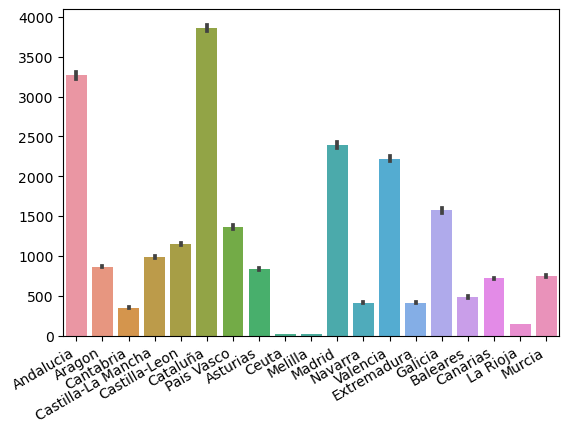

In [32]:
sns.barplot(data = demanda_ccaa)
plt.gcf().autofmt_xdate()
plt.show()

Observamos que hay Comunidades Autónomas que están sumamente infrarepresentadas, como La Rioja o Cantabria, y en parte esto se puede deber a lo que sucede con las ciudades autónomas de Ceuta y Melilla, que se deba exclusivamente a la variable poblacional que no se toma en cuenta. Por ello, tomaremos las poblaciones medias durante este período de tiempo, extraídas de la base de datos del ```Instituto Nacional de Estadística``` **(INE)** y los pondremos en proporción

In [34]:
censo = pd.read_excel("Data/Censo poblacional por CCAA - INE.xls", sheet_name="Sheet 1")

In [35]:
poblacion_media_ccaa = censo.drop('Fecha', axis = 1).apply(lambda x : x.mean()) # Obtenemos las medias del censo poblacional

In [36]:
demanda_ccaa_total = demanda_ccaa.drop('Fecha', axis = 1).apply(lambda x : sum(x)) # Obtenemos la demanda por CCAA

In [37]:
poblacion_media_ccaa

01 Andalucía                      8.419921e+06
02 Aragón                         1.326102e+06
06 Cantabria                      5.858114e+05
08 Castilla - La Mancha           2.063962e+06
07 Castilla y León                2.459213e+06
09 Cataluña                       7.598976e+06
16 País Vasco                     2.197516e+06
03 Asturias, Principado de        1.045380e+06
18 Ceuta                          8.426527e+04
19 Melilla                        8.467309e+04
13 Madrid, Comunidad de           6.556547e+06
15 Navarra, Comunidad Foral de    6.473403e+05
10 Comunitat Valenciana           5.030022e+06
11 Extremadura                    1.085990e+06
12 Galicia                        2.731770e+06
04 Balears, Illes                 1.127117e+06
05 Canarias                       2.128084e+06
17 Rioja, La                      3.189095e+05
14 Murcia, Región de              1.480722e+06
dtype: float64

In [38]:
demanda_ccaa_total

Andalucia             470499.01
Aragon                124631.94
Cantabria              50455.61
Castilla-La Mancha    142067.51
Castilla-Leon         165814.12
Cataluña              556321.29
Pais Vasco            196374.77
Asturias              120391.41
Ceuta                   2451.72
Melilla                 2517.30
Madrid                345054.73
Navarra                59375.26
Valencia              319663.28
Extremadura            59038.41
Galicia               226361.78
Baleares               69116.91
Canarias              103473.59
La Rioja               20310.18
Murcia                107284.75
dtype: float64

In [39]:
demanda_ccaa_prop = [(demanda_ccaa_total[i]/poblacion_media_ccaa[i])*100 for i in range(len(demanda_ccaa_total))]

demanda_ccaa_prop

[5.587926837315938,
 9.398364969220117,
 8.61294490547298,
 6.883241611401895,
 6.742567458840401,
 7.321003557728247,
 8.936215709009627,
 11.51651625745651,
 2.9095259774866813,
 2.972963397193915,
 5.262750658713534,
 9.172186947345242,
 6.3551067658404,
 5.436368193275526,
 8.286267326094784,
 6.132186416735346,
 4.862287969786569,
 6.368635269515084,
 7.245437221423439]

En contraste, observamos que hay un cambio notorio en la demanda por comunidades autónomas.
Antes eran Cataluña, Andalucía y Madrid las que más demanda energética suponían. No obstante, si tomamos en cuenta la proporción y sus respectivas poblaciones, Asturias, Aragón y Navarra son las que más consumen, mientras que Madrid y Andalucía pasan a ser de las que menos consumen, solo superadas por Ceuta, Melilla y Canarias

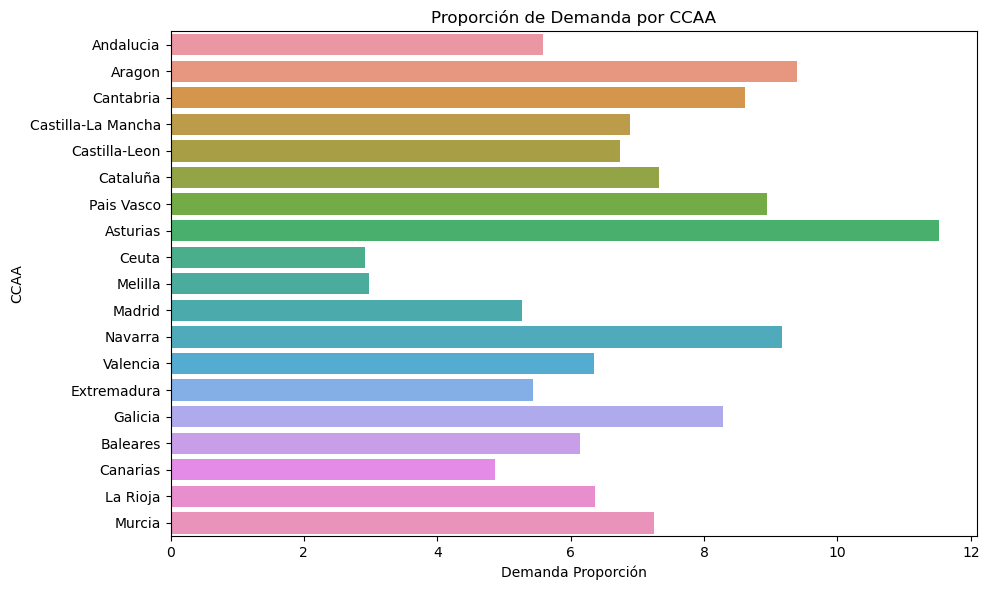

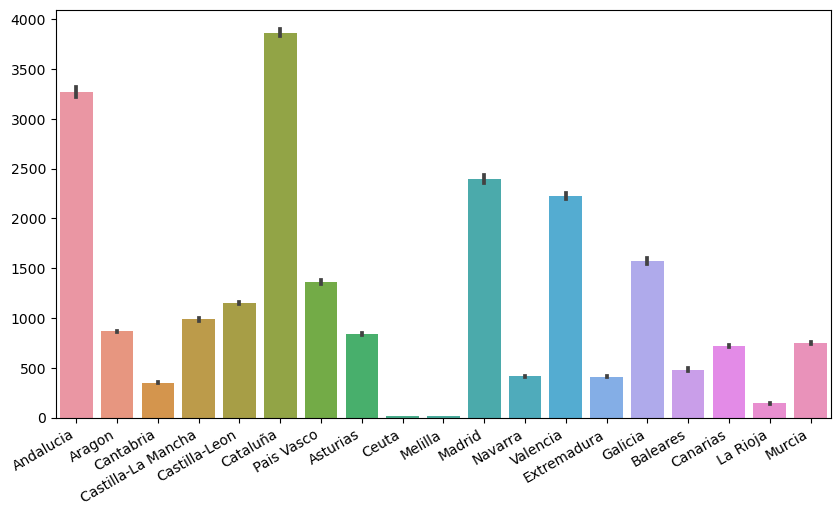

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x=demanda_ccaa_prop, y=demanda_ccaa.drop('Fecha', axis=1).columns, orient='h')
plt.xlabel('Demanda Proporción')
plt.ylabel('CCAA')
plt.title('Proporción de Demanda por CCAA')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data = demanda_ccaa)
plt.gcf().autofmt_xdate()
plt.show()

In [41]:
demanda_ccaa_prop = pd.DataFrame(data = demanda_ccaa_prop, columns = ['Demanda proporcional'],
                                 index                             = ['Andalucía', 'Aragon', 'Cantabria', 'Castilla-La Mancha',
                                                                      'Castilla-León', 'Cataluña', 'País Vasco', 'Asturias',
                                                                      'Ceuta', 'Melilla', 'Madrid', 'Navarra', 'Valencia',
                                                                      'Extremadura', 'Galicia', 'Baleares', 'Canarias', 'La Rioja',
                                                                      'Murcia'])

In [42]:
demanda_ccaa_prop.sort_values(by = 'Demanda proporcional', ascending = False)

Demanda proporcional
Asturias                       11.516516
Aragon                          9.398365
Navarra                         9.172187
País Vasco                      8.936216
Cantabria                       8.612945
Galicia                         8.286267
Cataluña                        7.321004
Murcia                          7.245437
Castilla-La Mancha              6.883242
Castilla-León                   6.742567
La Rioja                        6.368635
Valencia                        6.355107
Baleares                        6.132186
Andalucía                       5.587927
Extremadura                     5.436368
Madrid                          5.262751
Canarias                        4.862288
Melilla                         2.972963
Ceuta                           2.909526

In [43]:
demanda_ccaa_prop.to_csv("Demanda por comunidades autónomas en proporción a la población.csv")

----

## Intercambio

In [44]:
intercambio.head(5)

Fecha  Importacion Francia  Exportacion Francia  Importacion Portugal  \
0  2012-05-01               447.06              -213.03                229.83   
1  2012-06-01               576.57               -99.90                258.23   
2  2012-07-01               597.23              -100.17                174.65   
3  2012-08-01               489.40              -154.85                268.42   
4  2012-09-01               267.40              -197.85                221.00   

   Exportacion Portugal  Importacion Marruecos  Exportacion Marruecos  \
0               -938.56                   0.11                -419.67   
1               -940.76                   0.04                -409.67   
2               -831.04                   0.00                -470.13   
3               -725.32                   0.00                -509.04   
4               -838.71                   0.00                -482.00   

   Importacion Andorra  Exportacion Andorra  
0                  0.0               -10.98  
1                  0.0                -9.84  
2                  0.0                -0.06  
3                  0.0               -14.83  
4                  0.0               -17.13

De primeras se nos ocurre crear una nueva categoría con los saldos mensuales, que contendrían la misma información, pero resumida y, por tanto, quizás en mejor estado para los modelos predictivos

In [45]:
intercambio['Saldo Francia'] = intercambio['Importacion Francia'] - intercambio['Exportacion Francia']
intercambio['Saldo Portugal'] = intercambio['Importacion Portugal'] - intercambio['Exportacion Portugal']
intercambio['Saldo Marruecos'] = intercambio['Importacion Marruecos'] - intercambio['Exportacion Marruecos']
intercambio['Saldo Andorra'] = intercambio['Importacion Andorra'] - intercambio['Exportacion Andorra']

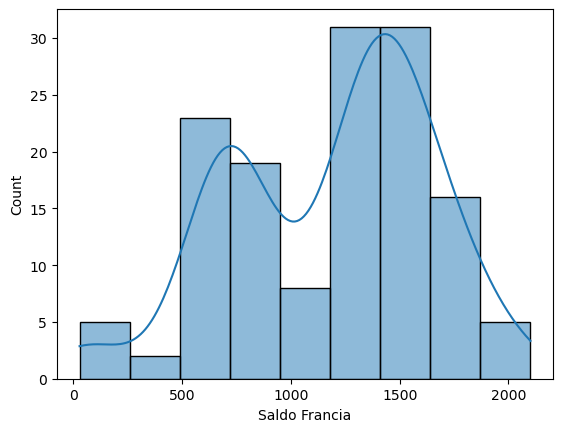

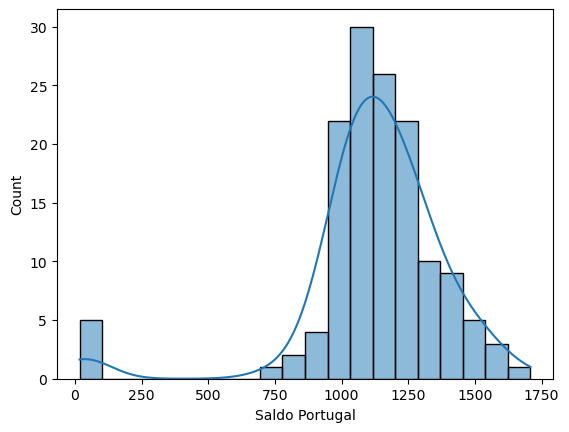

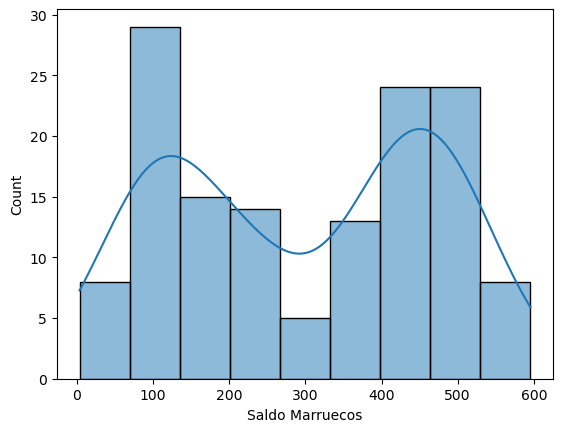

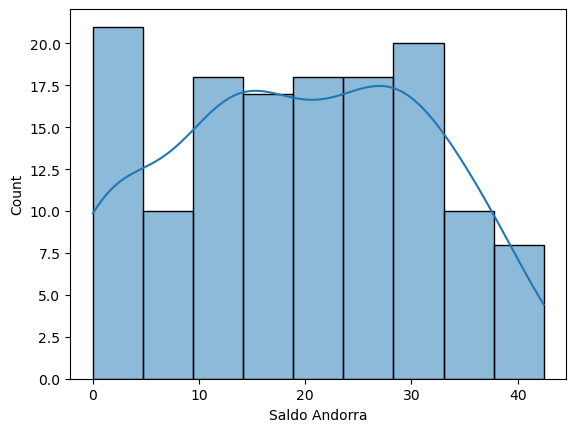

In [46]:
for i in ['Saldo Francia', 'Saldo Portugal', 'Saldo Marruecos', 'Saldo Andorra']:
    sns.histplot(intercambio[i], kde = True)
    plt.show()

Observamos que el saldo de Portugal presenta un problema de cola pesada, solo que al lado contrario para el que anteriormente aplicamos transformaciones logarítmicas. Es decir, que en este caso el sesgo es negativo en lugar de positivo. Cuando esto sucede, usualmente, una transformación posible es la de elevar al cuadrado, haciendo lo contrario que hace un logaritmo

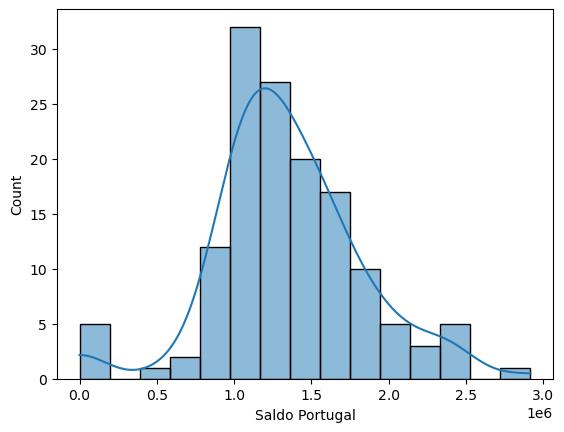

In [47]:
sns.histplot(intercambio['Saldo Portugal'].apply(lambda x : x**(2)), kde = True)
plt.show()

In [48]:
intercambio['Saldo Portugal'] = intercambio['Saldo Portugal'].apply(lambda x : x**2)

intercambio.to_csv('Intercambio (Actualizado).csv')

----

## Emisiones

In [49]:
emision.head(5)

Fechas  Emisiones Motores diésel  Emisiones Turbina de gas  \
0  2014-08-01                   7921.88                   2236.33   
1  2014-08-02                   7784.07                   1678.06   
2  2014-08-03                   7483.51                   1665.99   
3  2014-08-04                   8053.26                   2235.35   
4  2014-08-05                   7837.00                   2214.94   

   Emisiones Turbina de vapor  Emisiones Ciclo combinado  \
0                     5361.02                   30352.01   
1                     4751.97                   22092.77   
2                     4079.90                   26182.17   
3                     5407.29                   35543.03   
4                     5232.38                   37612.21   

   Emisiones Cogeneración  Emisiones Residuos no renovables  Total tCO2 eq.  \
0                25975.34                           1475.83       247145.18   
1                23523.61                           1471.15       201704.57   
2                21659.56                           1478.46       216905.44   
3                24336.56                           1309.36       261151.06   
4                25107.16                           1262.29       264824.36   

   tCO2 eq./MWh  Emisiones Carbón  
0          0.33         173822.78  
1          0.30         140402.94  
2          0.35         154355.84  
3          0.36         184266.22  
4          0.37         185558.37

In [50]:
px.line(data_frame = emision,
             y = 'tCO2 eq./MWh',
             x = 'Fechas',
             title = 'Toneladas de CO2 emitidas por megavatio hora consumido (Tendencia a lo largo del tiempo)')

In [51]:
px.histogram(data_frame = emision,
             x = 'tCO2 eq./MWh',
             nbins = 80,
             title = 'Toneladas de CO2 emitidas por megavatio hora consumido (Valores más frecuentes)',
             histnorm = 'density')

----

## Generación de energías

### Por renovables y no renovables

In [52]:
generacion_no_ren.head(4)

Fechas  Generación Renovables GWh  Generación No renovables GWh
0  2014-08-01                     251.77                        499.57
1  2014-08-02                     242.18                        429.53
2  2014-08-03                     166.05                        450.89
3  2014-08-04                     204.51                        518.00

In [53]:
generacion_no_ren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3298 entries, 0 to 3297
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Fechas                        3298 non-null   object 
 1   Generación Renovables GWh     3298 non-null   float64
 2   Generación No renovables GWh  3298 non-null   float64
dtypes: float64(2), object(1)
memory usage: 77.4+ KB


Mientras que la generación de energías renovables muestra una tendencia creciente con el tiempo, además de una serie temporal estacionalizada, la generación de energías no renovables muestra una tendencia mínimamente decreciente, apuntando a ser casi constante en el tiempo, y siendo también una serie temporal estacionalizada, algo a tomar en cuenta a la hora de realizar predicciones

In [54]:
px.line(data_frame = generacion_no_ren,
             y = 'Generación Renovables GWh',
             x = 'Fechas',
             title = 'Evolución de la generación de energías renovables con el tiempo')

In [55]:
px.line(data_frame = generacion_no_ren,
             y = 'Generación No renovables GWh',
             x = 'Fechas',
             title = 'Evolución de la generación de energías NO renovables con el tiempo')

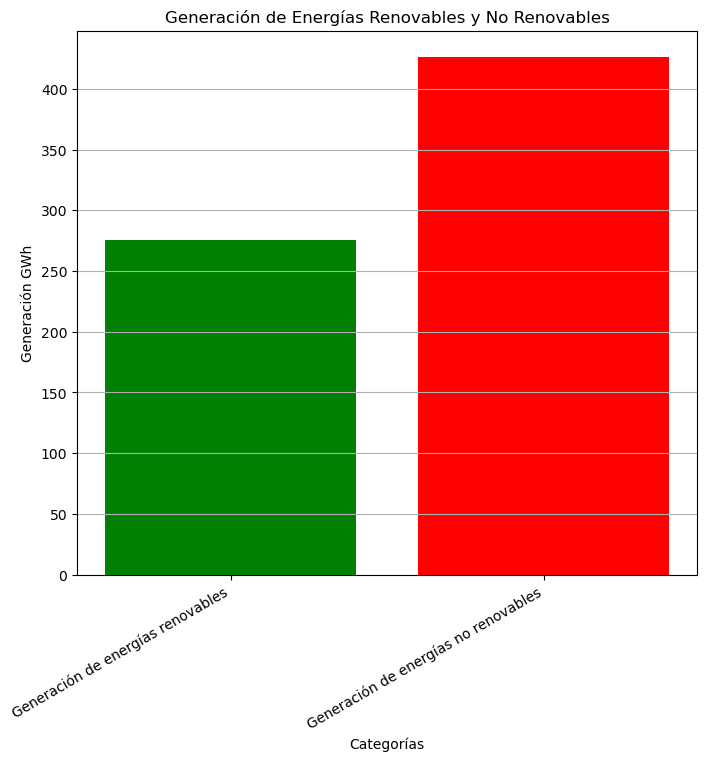

In [56]:
plt.figure(figsize = (8, 8))
categorias = ['Generación de energías renovables', 'Generación de energías no renovables']
valores = [generacion_no_ren['Generación Renovables GWh'].median(),
           generacion_no_ren['Generación No renovables GWh'].median()]

plt.bar(categorias, valores, color = ['green', 'red'])

plt.xlabel('Categorías')
plt.ylabel('Generación GWh')
plt.title('Generación de Energías Renovables y No Renovables')
plt.gcf().autofmt_xdate()
plt.grid(axis = 'y')
plt.show()

### Generación de energía por tecnología

In [57]:
generacion.head(5)

Fechas  Generación Hidráulica GWh  Generación Nuclear GWh  \
0  2014-08-01                      72.26                  144.09   
1  2014-08-02                      61.77                  143.48   
2  2014-08-03                      55.57                  143.32   
3  2014-08-04                      75.06                  144.01   
4  2014-08-05                      77.45                  143.56   

   Generación Carbón GWh  Generación Motores diésel GWh  \
0                 182.97                           9.95   
1                 147.79                           9.79   
2                 162.48                           9.40   
3                 193.96                          10.10   
4                 195.32                           9.82   

   Generación Turbina de gas GWh  Generación Turbina de vapor GWh  \
0                           3.37                             6.02   
1                           2.77                             5.34   
2                           2.75                             4.58   
3                           3.39                             6.08   
4                           3.32                             5.88   

   Generación Ciclo combinado GWh  Generación Hidroeólica GWh  \
0                           72.49                        0.01   
1                           50.52                        0.01   
2                           61.77                        0.01   
3                           86.47                        0.01   
4                           91.95                        0.01   

   Generación Eólica GWh  Generación Solar fotovoltaica GWh  \
0                 119.24                              27.77   
1                 117.57                              27.90   
2                  41.36                              30.14   
3                  56.16                              30.94   
4                  51.62                              31.51   

   Generación Otras renovables GWh  Generación Cogeneración GWh  \
0                            11.44                        68.36   
1                            11.56                        61.90   
2                            11.49                        57.00   
3                            11.92                        64.04   
4                            11.76                        66.07   

   Generación Residuos no renovables GWh  Generación Residuos renovables GWh  \
0                                   6.15                                2.20   
1                                   6.13                                2.10   
2                                   6.16                                2.05   
3                                   5.46                                1.37   
4                                   5.26                                1.68   

   Generación Solar térmica GWh  
0                         18.85  
1                         21.27  
2                         25.43  
3                         29.06  
4                         30.11

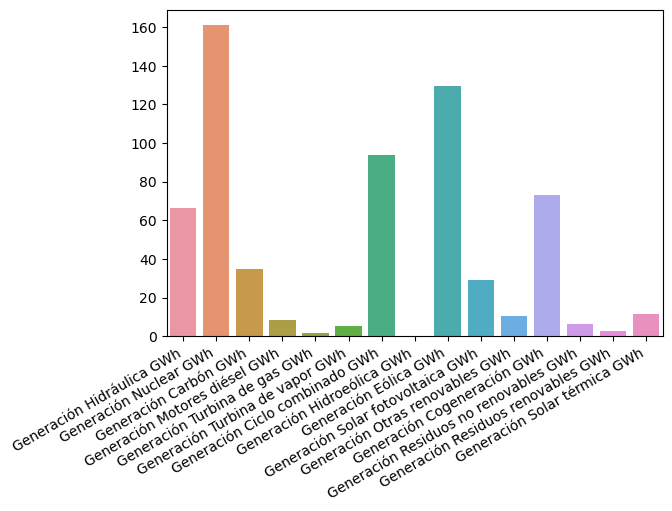

In [58]:
sns.barplot(x = generacion.drop('Fechas', axis = 1).columns,
            y = generacion.drop('Fechas', axis = 1).median())
plt.gcf().autofmt_xdate()

Resulta enormemente curioso que la generación nuclear sea la principal fuente de generación de energía pese a los esfuerzos, tanto nacionales como internacionales por parte de la Unión Europea, para disminuir la generación de energía por parte de esta fuente (https://www.antena3.com/noticias/economia/apagon-nuclear-asi-iran-cerrando-centrales-nucleares-hay-cambios-antes-2024_202303316426e3187e9ad300014d11db.html)

Por otro lado, también resulta llamativo que la generación de energía renovable solar es inferior a la eólica y la hidráulica, a pesar de que España es el país de Europa con más horas de luz solar por año. Aun así, podemos apreciar que la tendencia es creciente, ante lo cual se observa cómo se está tratando de revertir la situación para aprovechar este hecho

In [59]:
px.line(data_frame = generacion,
        x = 'Fechas',
        y = 'Generación Solar fotovoltaica GWh',
        title = 'Tendencia de generación energética de fuente solar')

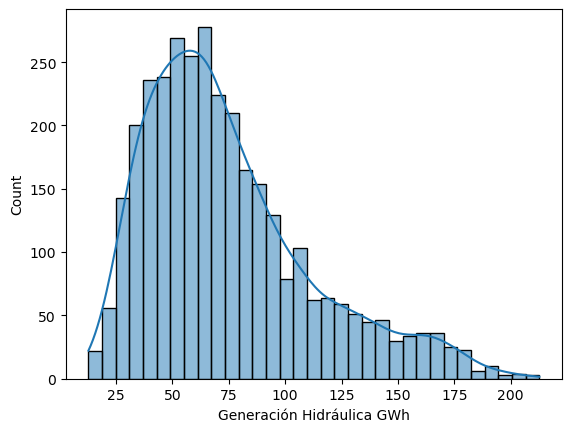

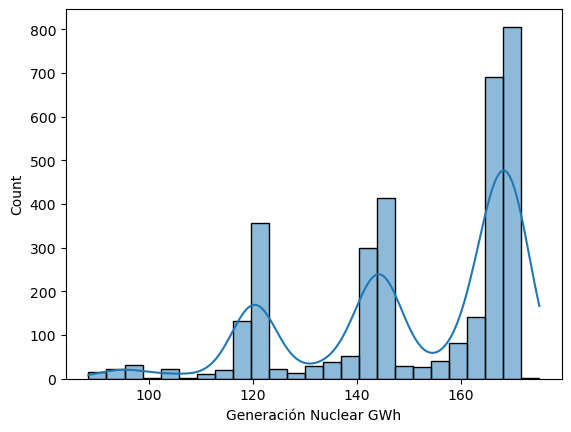

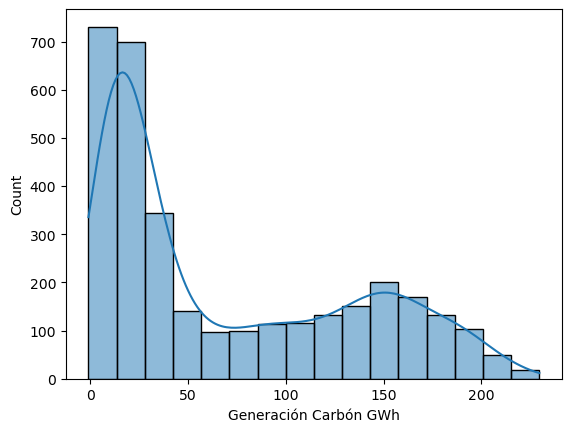

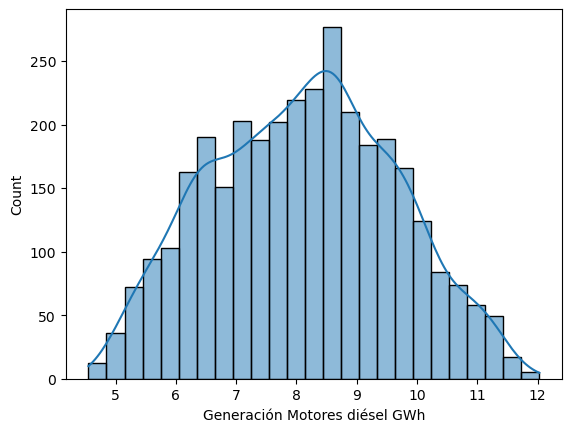

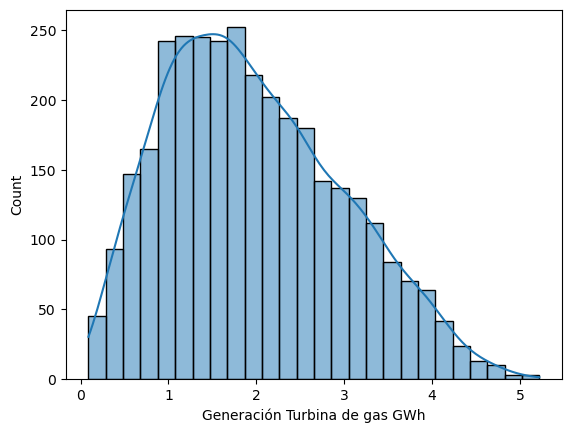

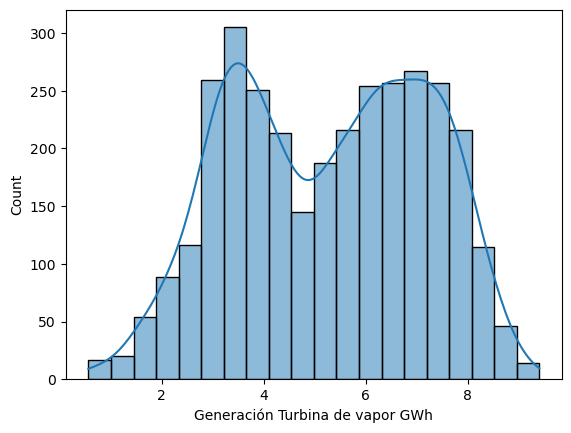

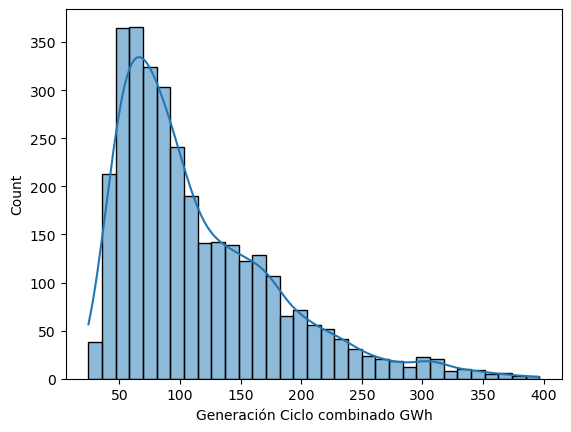

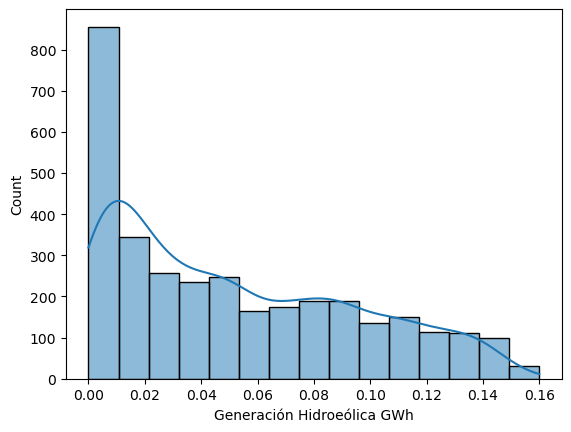

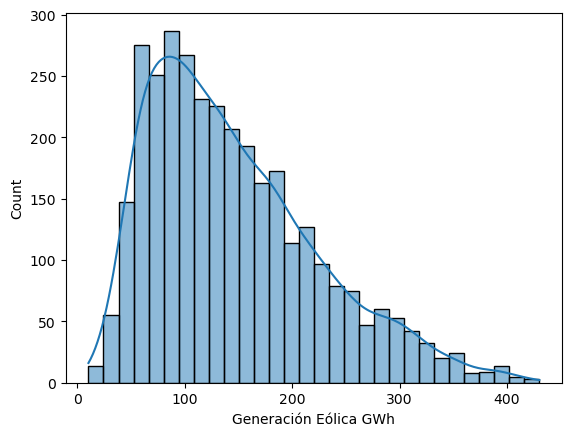

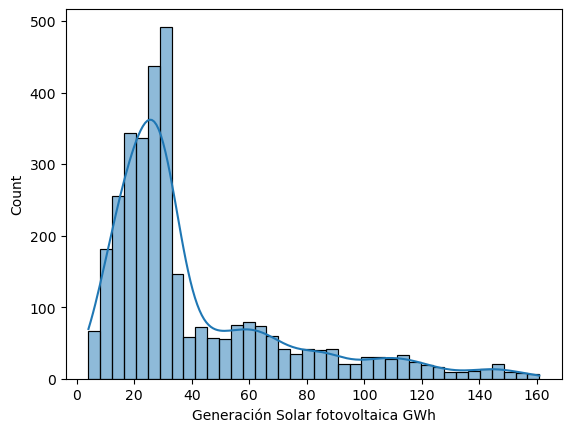

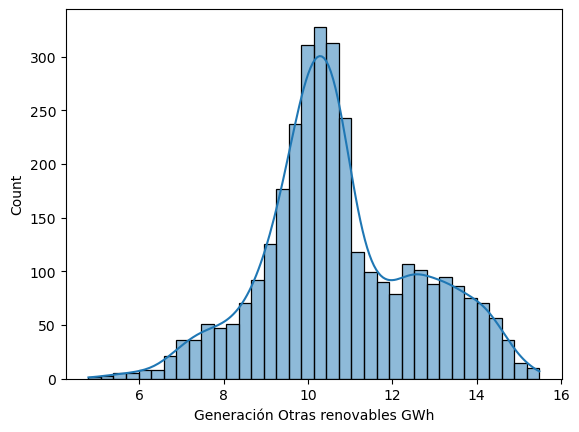

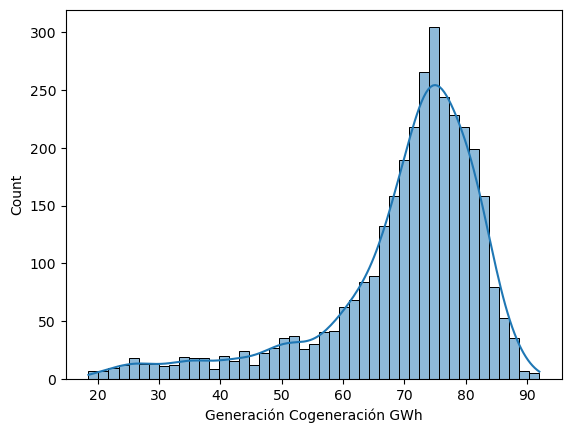

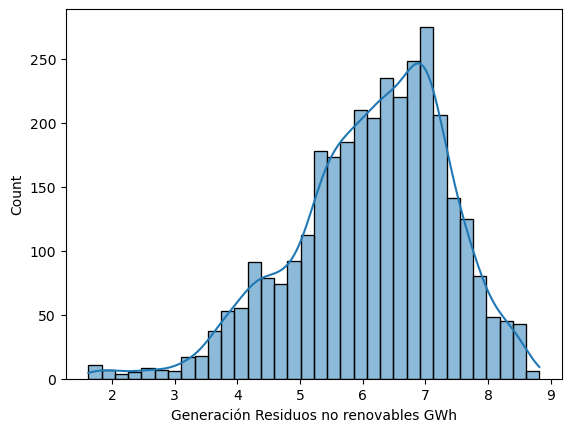

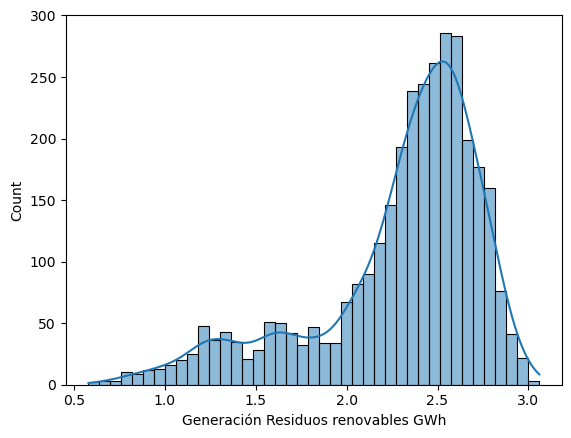

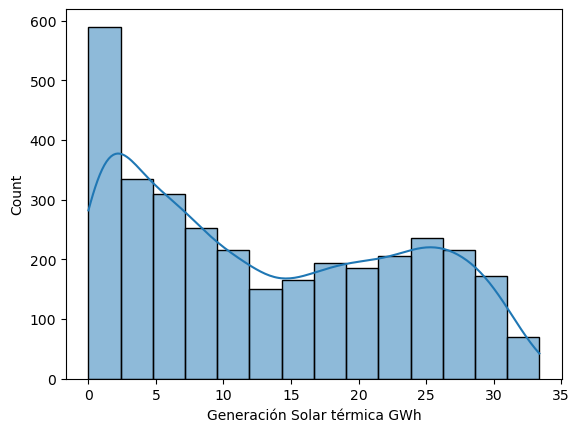

In [60]:
for column in generacion.drop('Fechas', axis = 1).columns:
    sns.histplot(generacion[column], kde = True)
    plt.show()

Enlistamos las variables que podrían rendir mejor con transformaciones logarítmicas:
- Generación hidráulica
- Generación carbón
- Generación ciclo combinado
- Generación hidroeólica
- Generación eólica
- Generación solar fotovoltaica

Por otro lado, datos que podrían rendir mejor si se elevasen al cuadrado serían:
- Generación de residuos por parte de las renovables
- Generación de residuos por parte de las no renovables
- Generación cogeneración

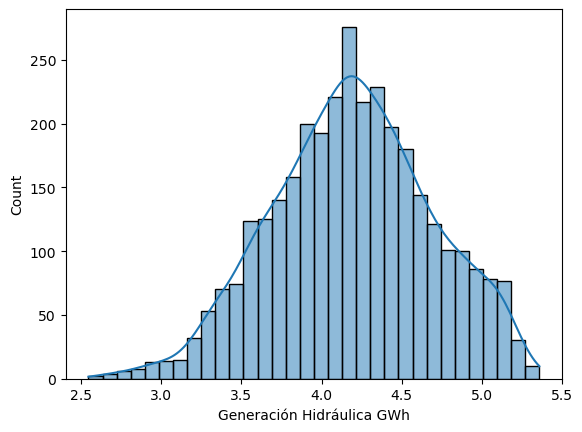

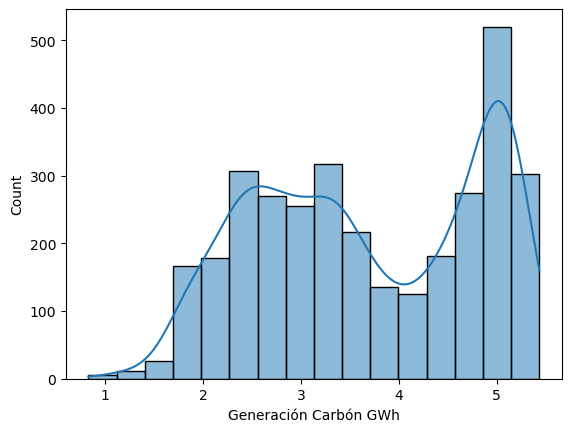

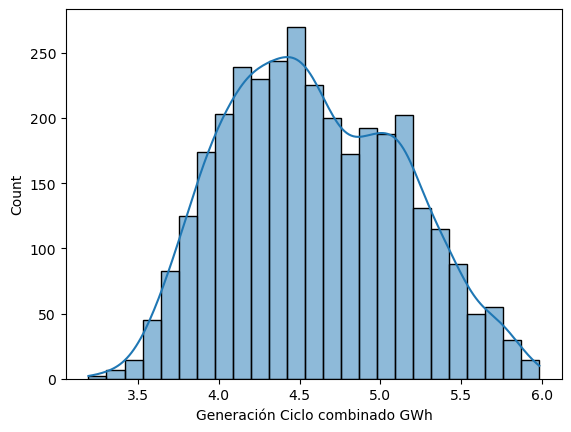

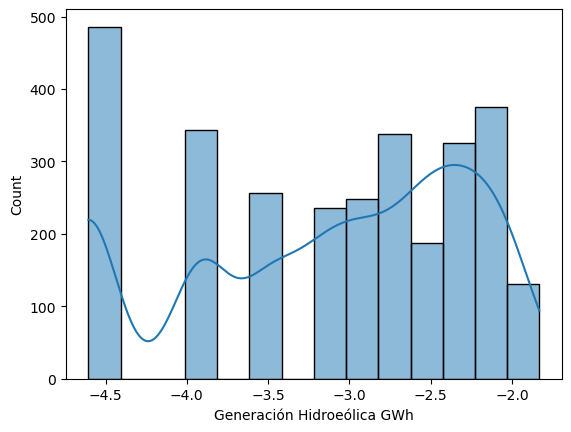

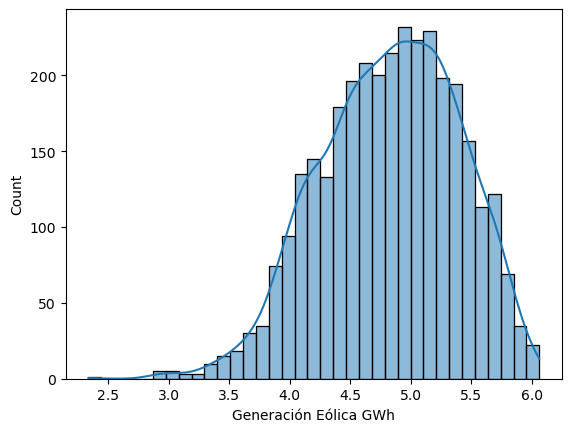

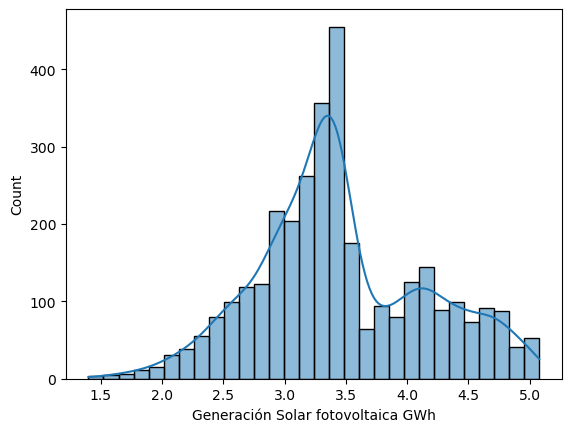

In [61]:
for i in ['Generación Hidráulica GWh', 'Generación Carbón GWh', 'Generación Ciclo combinado GWh', 'Generación Hidroeólica GWh',
          'Generación Eólica GWh', 'Generación Solar fotovoltaica GWh']:
    sns.histplot(np.log(generacion[i]), kde = True)
    plt.show()

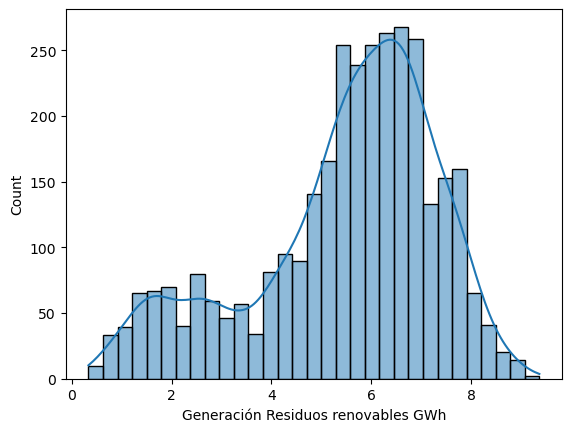

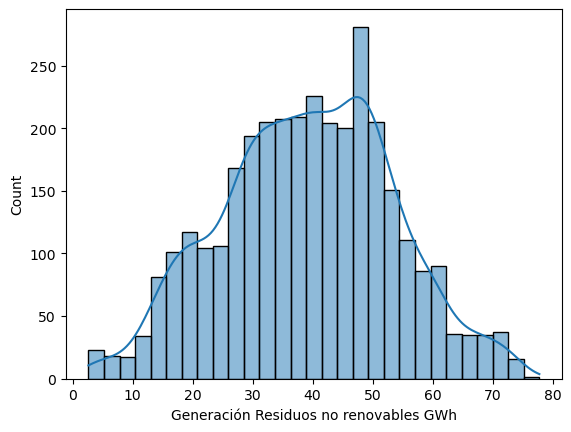

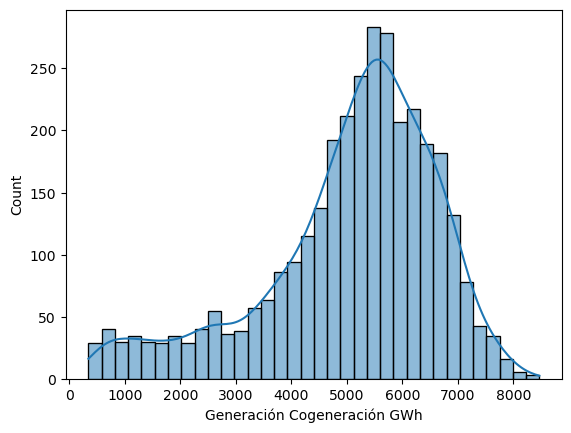

In [62]:
for i in ['Generación Residuos renovables GWh', 'Generación Residuos no renovables GWh', 'Generación Cogeneración GWh']:
    sns.histplot(generacion[i].apply(lambda x : x**2), kde = True)
    plt.show()

In [63]:
for i in ['Generación Hidráulica GWh', 'Generación Carbón GWh', 'Generación Ciclo combinado GWh', 'Generación Hidroeólica GWh',
          'Generación Eólica GWh', 'Generación Solar fotovoltaica GWh']:
    generacion[i] = np.log(generacion[i])

In [64]:
for i in ['Generación Residuos renovables GWh', 'Generación Residuos no renovables GWh', 'Generación Cogeneración GWh']:
    generacion[i] = generacion[i].apply(lambda x : x**2)

In [65]:
generacion.to_csv('Generación por tecnología - Transformada.csv')